In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from modules.env import MazeVisualization
from utils.skeletonize import skeletonize_env, draw_graph_with_curved_edges
import seaborn as sns
from matplotlib.patches import Circle
import matplotlib
import pickle
import matplotlib.gridspec as gridspec

%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['ps.fonttype'] = 42
rcParams['font.sans-serif'] = ['Arial']  # 예시: Arial로 설정
rcParams['font.family'] = 'sans-serif'

sns.set_style(
    'ticks',
    rc={
        'xtick.direction': 'in',  # x축 tick을 안쪽으로
        'ytick.direction': 'in',  # y축 tick을 안쪽으로
    }
)
rcParams["figure.dpi"] = 600
# Set the font to Arial
big_font = 20
mid_font = 15
small_font = 12

indicator_font = big_font
legend_font = mid_font
title_font = mid_font
axis_font = mid_font
tick_font = small_font



subplot_scale_factor = 3

indicator_x_loc = -0.1
indicator_y_loc = 1.15

node_size = 300
edge_width = 4

junction_color = "#416788"
deadend_color = "#646464"
edge_color = "#E1DAD2"

palette = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']

In [2]:
num_episodes = 1000

optimal_discounted_return_list = np.zeros((10, 100, 5))
tag_discounted_return_list = np.zeros((10, 100, 5))
sr_discounted_return_list = np.zeros((10, 100, 5))
dr_discounted_return_list = np.zeros((10, 100, 5))
discounted_return_list_list = np.zeros((10, 100, 5, num_episodes))
for ratio_index in range(1, 11):
    for index in range(1, 101):
        for seed in range(5):
            with open(f"data/multi_subgoals/raw_data/results_{ratio_index}_{index}_{seed}.pkl", 'rb') as file:
                (
                    optimal_discounted_return,
                    agent_discounted_return,
                    discounted_return_list,
                ) = pickle.load(file)
                optimal_discounted_return_list[ratio_index-1, index-1, seed] = optimal_discounted_return
                tag_discounted_return_list[ratio_index-1, index-1, seed] = agent_discounted_return[0]
                sr_discounted_return_list[ratio_index-1, index-1, seed] = agent_discounted_return[1]
                dr_discounted_return_list[ratio_index-1, index-1, seed] = agent_discounted_return[2]
                discounted_return_list_list[ratio_index - 1, index - 1, seed] = (
                    discounted_return_list[:num_episodes]
                )

optimal_reward_per_timestep_list = []
tag_reward_per_timestep_list = []
sr_reward_per_timestep_list = []
dr_reward_per_timestep_list = []
sfql_reward_per_timestep_list_list = []
for ratio_index in range(1, 11):
    for index in range(1, 101):
        for seed in range(5):
            with open(f"data/multi_subgoals/raw_data/reward_per_timestep_{ratio_index}_{index}_{seed}.pkl", 'rb') as file:
                (
                    optimal_reward_per_timestep,
                    agent_reward_per_timestep,
                    sfql_reward_per_timestep_list,
                ) = pickle.load(file)
                optimal_reward_per_timestep_list.append(optimal_reward_per_timestep)
                tag_reward_per_timestep_list.append(agent_reward_per_timestep[0])
                sr_reward_per_timestep_list.append(agent_reward_per_timestep[1])
                dr_reward_per_timestep_list.append(agent_reward_per_timestep[2])
                sfql_reward_per_timestep_list_list.append(
                    sfql_reward_per_timestep_list[:num_episodes]
                )

gamma = 0.9999

optimal_discounted_return_list_mod = []
tag_discounted_return_list_mod = []
sr_discounted_return_list_mod = []
dr_discounted_return_list_mod = []
sfql_discounted_return_list_list_mod = []
for i in range(5000):
    optimal_discounted_return_mod = 0
    for r, t in optimal_reward_per_timestep_list[i]:
        optimal_discounted_return_mod += (gamma ** t) * r
    optimal_discounted_return_list_mod.append(optimal_discounted_return_mod)

    tag_discounted_return_mod = 0
    for r, t in tag_reward_per_timestep_list[i]:
        tag_discounted_return_mod += (gamma ** t) * r
    tag_discounted_return_list_mod.append(tag_discounted_return_mod)

    sr_discounted_return_mod = 0
    for r, t in sr_reward_per_timestep_list[i]:
        sr_discounted_return_mod += (gamma ** t) * r
    sr_discounted_return_list_mod.append(sr_discounted_return_mod)

    dr_discounted_return_mod = 0
    for r, t in dr_reward_per_timestep_list[i]:
        dr_discounted_return_mod += (gamma ** t) * r
    dr_discounted_return_list_mod.append(dr_discounted_return_mod)

    sfql_discounted_return_list_mod = []
    for j in range(num_episodes):
        sfql_discounted_return_mod = 0
        for r, t in sfql_reward_per_timestep_list_list[i][j]:
            sfql_discounted_return_mod += (gamma ** t) * r
        sfql_discounted_return_list_mod.append(sfql_discounted_return_mod)
    sfql_discounted_return_list_list_mod.append(sfql_discounted_return_list_mod)

tag_discrepancy = [- optimal_discounted_return_list_mod[i] + tag_discounted_return_list_mod[i] for i in range(5000)]
sr_discrepancy = [- optimal_discounted_return_list_mod[i] + sr_discounted_return_list_mod[i] for i in range(5000)]
dr_discrepancy = [- optimal_discounted_return_list_mod[i] + dr_discounted_return_list_mod[i] for i in range(5000)]
sfql_discrepancy = [
    [
        -optimal_discounted_return_list_mod[i]
        + sfql_discounted_return_list_list_mod[i][j]
        for j in range(num_episodes)
    ]
    for i in range(5000)
]

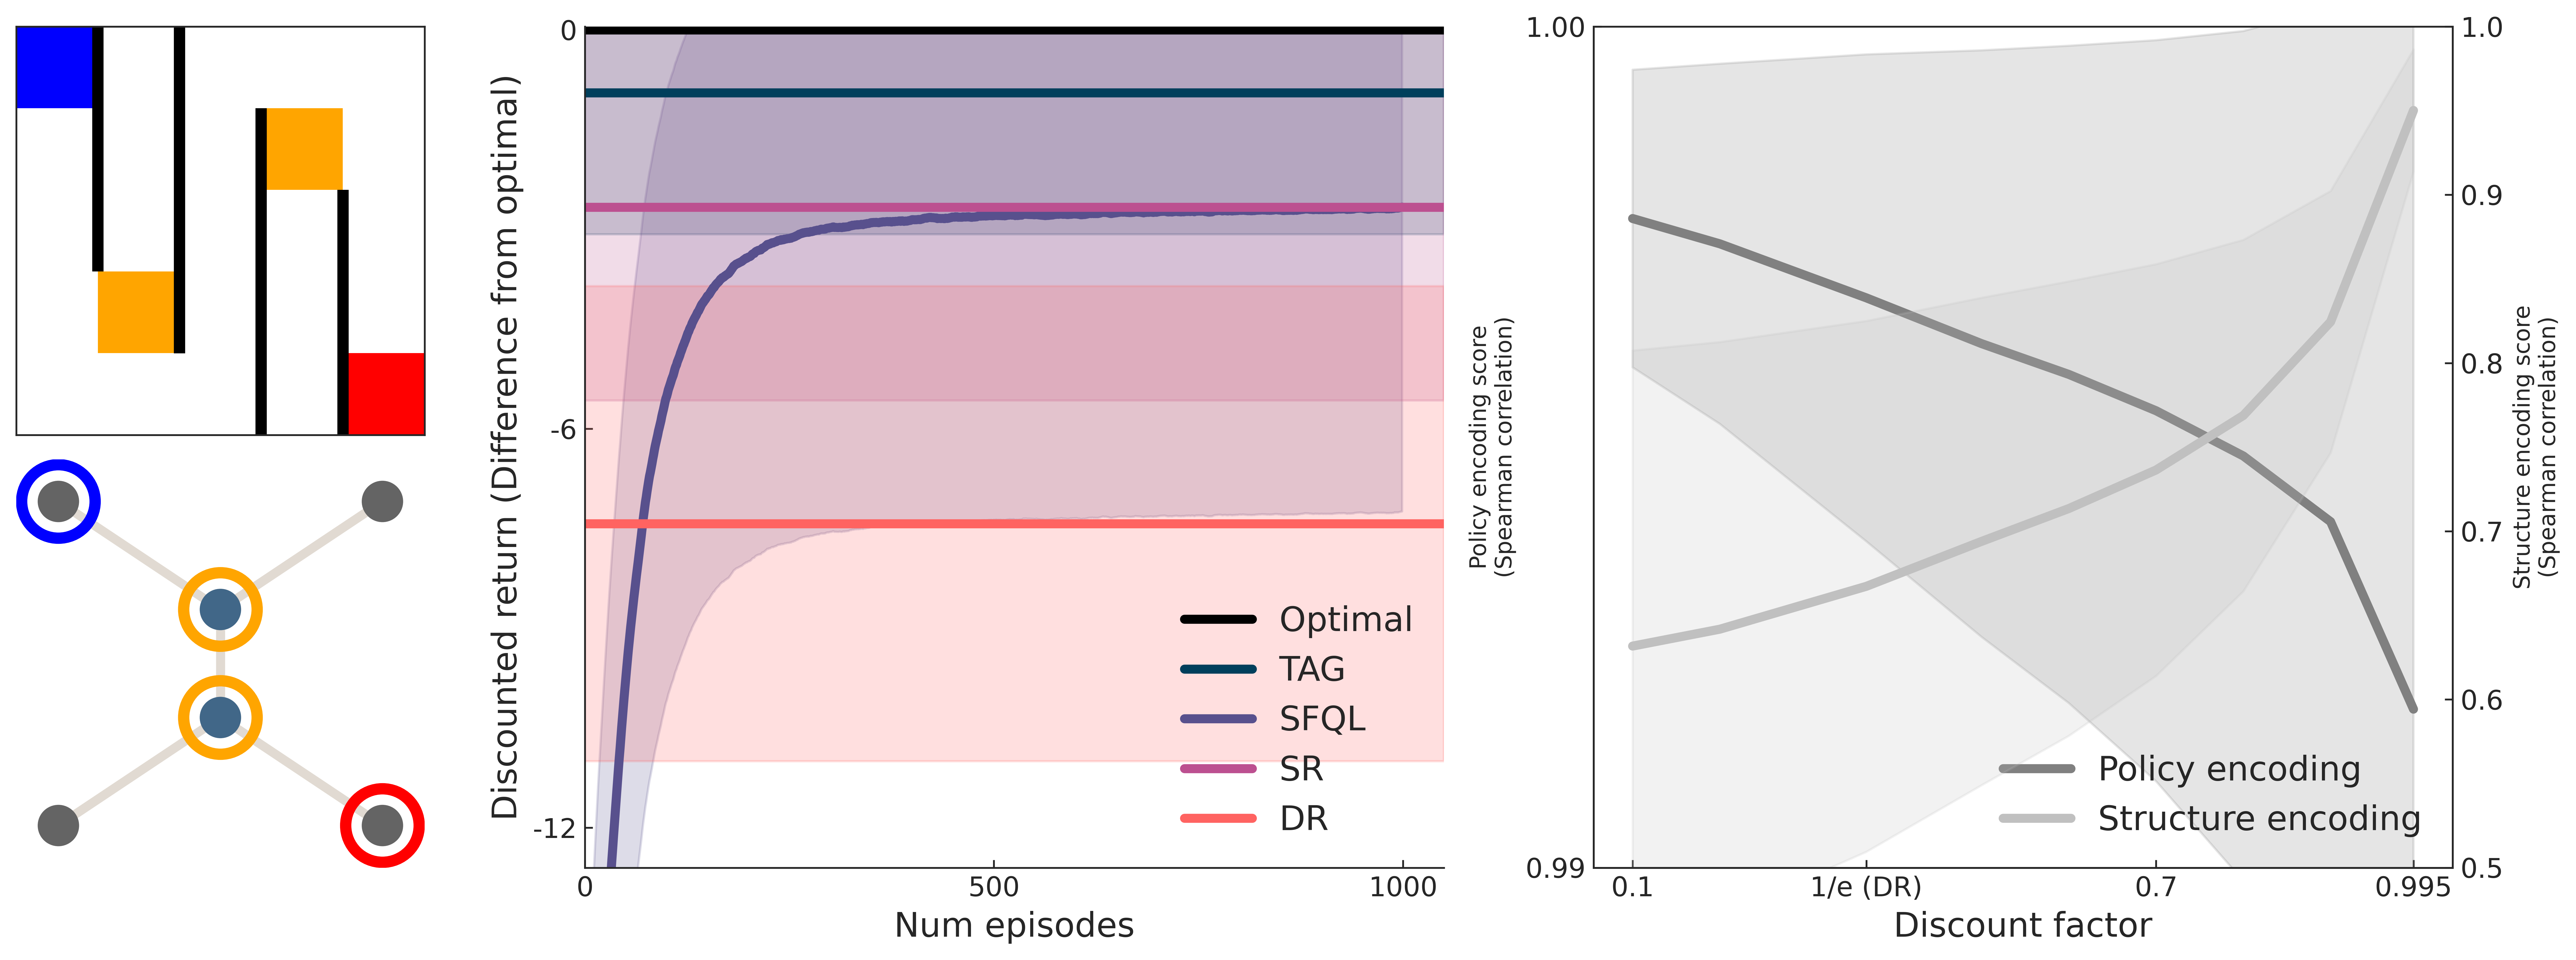

In [3]:
import pickle

num_row, num_column = 2, 3
figsize_x = np.min([num_column * subplot_scale_factor, 20])
figsize_y = figsize_x * num_row / num_column
fig = plt.figure(figsize=(figsize_x + 7, figsize_y))
gs = gridspec.GridSpec(num_row, num_column, figure=fig, height_ratios=[1 for _ in range(num_row)], width_ratios=[0.5, 1, 1])

ax_env = fig.add_subplot(gs[0, 0])
ax_topology = fig.add_subplot(gs[1, 0])
ax_performance = fig.add_subplot(gs[0:2, 1])
ax_tradeoff = fig.add_subplot(gs[0:2, 2])

env1 = MazeVisualization(5, 5)
walls1 = [
    (0, 1), (1, 2), (5, 6), (6, 7), (7, 8), (10, 11), (11, 12), (12, 13), (13, 14),
    (16, 17), (17, 18), (18, 19), (22, 23), (23, 24)
]
env1.update_map(walls=walls1)
env1.visualize(ax=ax_env, subgoals=[16, 8])
vertex_nodes, deadend_nodes, edge_nodes, simplified_G, image_original, skeleton, vertex_corresp, deadend_corresp, edge_corresp, _, _, _ = skeletonize_env(env1)
pos = {
    (0, 0): (0, 6),
    (0, 1): (4, 6),
    (3, 0): (2, 4),
    (1, 3): (2, 2),
    (4, 3): (0, 0),
    (4, 4): (4, 0)
}
draw_graph_with_curved_edges(simplified_G, '', rad=0.2, self_loop_rad=1, save=True, pos=pos, ax=ax_topology, set_margin=True, node_size=node_size, edge_width=edge_width)

# 노드 위치 정규화 (0과 1 사이)
x_min, x_max = ax_topology.get_xlim()
y_min, y_max = ax_topology.get_ylim()

normalized_pos = {}
for node, (x, y) in pos.items():
    x_norm = (x - x_min) / (x_max - x_min)
    y_norm = (y - y_min) / (y_max - y_min)
    normalized_pos[node] = (x_norm, y_norm)


circle_start = Circle(normalized_pos[(0, 0)], 0.09, edgecolor="blue", facecolor='none', transform=ax_topology.transAxes, linewidth=5)
circle_goal = Circle(normalized_pos[(4, 4)], 0.09, edgecolor="red", facecolor='none', transform=ax_topology.transAxes, linewidth=5)
circle_subgoal_1 = Circle(normalized_pos[(3, 0)], 0.09, edgecolor="orange", facecolor='none', transform=ax_topology.transAxes, linewidth=5)
circle_subgoal_2 = Circle(normalized_pos[(1, 3)], 0.09, edgecolor="orange", facecolor='none', transform=ax_topology.transAxes, linewidth=5)
ax_topology.add_patch(circle_start)
ax_topology.add_patch(circle_goal)
ax_topology.add_patch(circle_subgoal_1)
ax_topology.add_patch(circle_subgoal_2)
ax_topology.set_aspect((x_max - x_min) / (y_max - y_min))



def smooth_data(data, window_size):
    """
    Smooths the time series data along the time axis using a moving average filter with padding.
    
    Parameters:
    data (numpy array): The 2D time series data (num_data x time).
    window_size (int): The size of the moving window.
    
    Returns:
    numpy array: The smoothed time series data.
    """
    def smooth_row(row):
        # Create a moving average filter
        window = np.ones(window_size) / window_size
        
        # Pad the series to handle the edges
        pad_width = window_size // 2
        padded_row = np.pad(row, (pad_width, pad_width), mode='edge')
        
        # Apply the filter to the padded series using np.convolve with 'same' mode
        smoothed_row = np.convolve(padded_row, window, mode='same')[pad_width:-pad_width]
        
        return smoothed_row
    
    # Apply the smoothing function to each row (time axis)
    smoothed_data = np.apply_along_axis(smooth_row, axis=1, arr=data)
    
    return smoothed_data

sfql_discrepancy = np.array(sfql_discrepancy)
sfql_discrepancy = smooth_data(sfql_discrepancy, 10)

# optimal_discounted_return_mean_all = np.mean(optimal_discounted_return_list, axis=(1, 2))
tag_discounted_return_mean_all = np.mean(tag_discrepancy)
sr_discounted_return_mean_all = np.mean(sr_discrepancy)
dr_discounted_return_mean_all = np.mean(dr_discrepancy)
discounted_return_list_mean_all = np.mean(sfql_discrepancy, axis=(0))

# optimal_discounted_return_std_all = np.std(optimal_discounted_return_list, axis=(1, 2))
'''tag_discounted_return_ci_all = np.std(tag_discrepancy, ddof=1) / np.sqrt(len(tag_discrepancy)) * 10
sr_discounted_return_ci_all = np.std(sr_discrepancy, ddof=1) / np.sqrt(len(sr_discrepancy)) * 10
dr_discounted_return_ci_all = np.std(dr_discrepancy, ddof=1) / np.sqrt(len(dr_discrepancy)) * 10
discounted_return_list_ci_all = np.std(sfql_discrepancy, axis=(0), ddof=1) / np.sqrt(np.array(sfql_discrepancy).shape[0]) * 10'''
tag_discounted_return_std_all = np.std(tag_discrepancy)
sr_discounted_return_std_all = np.std(sr_discrepancy)
dr_discounted_return_std_all = np.std(dr_discrepancy)
discounted_return_list_std_all = np.std(sfql_discrepancy)

# Plotting the optimal discounted return mean as a horizontal line


# plt.axhline(y=0, color="black", linestyle="-", label="Optimal")

# Plotting the agent discounted return mean as a horizontal line
ax_performance.axhline(
    y=0,
    color='black',
    linestyle="-",
    label="Optimal",
    lw=4,
)
ax_performance.axhline(
    y=tag_discounted_return_mean_all,
    # color=plt.cm.tab10(3),
    color=palette[0],
    linestyle="-",
    label="TAG",
    lw=4,
)

ax_performance.axhspan(
    tag_discounted_return_mean_all - tag_discounted_return_std_all,
    tag_discounted_return_mean_all + tag_discounted_return_std_all,
    # color=plt.cm.tab10(3),
    color=palette[0],
    alpha=0.2,
)

ax_performance.plot(
    np.arange(len(discounted_return_list_mean_all)),
    discounted_return_list_mean_all,
    label="SFQL",
    # color=plt.cm.tab10(0),
    color=palette[1],
    lw=4,
)
ax_performance.fill_between(
    np.arange(len(discounted_return_list_mean_all)),
    discounted_return_list_mean_all
    - discounted_return_list_std_all,
    discounted_return_list_mean_all
    + discounted_return_list_std_all,
    alpha=0.2,
    #color=plt.cm.tab10(0),
    color=palette[1],
)

ax_performance.axhline(
    y=sr_discounted_return_mean_all,
    # color=plt.cm.tab10(2),
    color=palette[2],
    linestyle="-",
    label="SR",
    lw=4,
)

ax_performance.axhspan(
    sr_discounted_return_mean_all - sr_discounted_return_std_all,
    sr_discounted_return_mean_all + sr_discounted_return_std_all,
    # color=plt.cm.tab10(42),
    color=palette[2],
    alpha=0.2,
)

ax_performance.axhline(
    y=dr_discounted_return_mean_all,
    # color=plt.cm.tab10(1),
    color=palette[3],
    linestyle="-",
    label="DR",
    lw=4,
)

ax_performance.axhspan(
    dr_discounted_return_mean_all - dr_discounted_return_std_all,
    dr_discounted_return_mean_all + dr_discounted_return_std_all,
    # color=plt.cm.tab10(1),
    color=palette[3],
    alpha=0.2,
)
ax_performance.set_xticks([0, 500, 1000])
ax_performance.set_xticklabels([0, 500, 1000], fontsize=tick_font)
ax_performance.set_yticks([-12, -6, 0])
ax_performance.set_yticklabels([-12, -6, 0], fontsize=tick_font)
ax_performance.spines['top'].set_visible(False)
ax_performance.spines['right'].set_visible(False)

ax_performance.set_ylim(-12 - 0.6, 0.05)
ax_performance.set_xlim(0, 1050)

ax_performance.set_xlabel("Num episodes", fontsize=axis_font)
ax_performance.set_ylabel("Discounted return (Difference from optimal)", fontsize=axis_font)
ax_performance.tick_params(axis='x', labelsize=tick_font)
ax_performance.tick_params(axis='y', labelsize=tick_font)
ax_performance.legend(fontsize=legend_font, loc='lower right', frameon=False)



sr_filenames_mean = [
    "value_sr_spearmanr_mean_unbiased_0.99.npy",
    "value_sr_spearmanr_mean_unbiased_0.90.npy",
    "value_sr_spearmanr_mean_unbiased_0.80.npy",
    "value_sr_spearmanr_mean_unbiased_0.70.npy",
    "value_sr_spearmanr_mean_unbiased_0.60.npy",
    "value_sr_spearmanr_mean_unbiased_0.50.npy",
    "value_sr_spearmanr_mean_unbiased_0.37.npy",
    "value_sr_spearmanr_mean_unbiased_0.20.npy",
    "value_sr_spearmanr_mean_unbiased_0.10.npy",
]
sr_filenames_std = [
    "value_sr_spearmanr_std_unbiased_0.99.npy",
    "value_sr_spearmanr_std_unbiased_0.90.npy",
    "value_sr_spearmanr_std_unbiased_0.80.npy",
    "value_sr_spearmanr_std_unbiased_0.70.npy",
    "value_sr_spearmanr_std_unbiased_0.60.npy",
    "value_sr_spearmanr_std_unbiased_0.50.npy",
    "value_sr_spearmanr_std_unbiased_0.37.npy",
    "value_sr_spearmanr_std_unbiased_0.20.npy",
    "value_sr_spearmanr_std_unbiased_0.10.npy",
]
diff_filenames_mean = [
    "value_diffdist_spearmanr_mean_unbiased_calc_successor_map_0.99_99.npy",
    "value_diffdist_spearmanr_mean_unbiased_calc_successor_map_0.90_99.npy",
    "value_diffdist_spearmanr_mean_unbiased_calc_successor_map_0.80_99.npy",
    "value_diffdist_spearmanr_mean_unbiased_calc_successor_map_0.70_99.npy",
    "value_diffdist_spearmanr_mean_unbiased_calc_successor_map_0.60_99.npy",
    "value_diffdist_spearmanr_mean_unbiased_calc_successor_map_0.50_99.npy",
    "value_diffdist_spearmanr_mean_unbiased_calc_successor_map_0.37_99.npy",
    "value_diffdist_spearmanr_mean_unbiased_calc_successor_map_0.20_99.npy",
    "value_diffdist_spearmanr_mean_unbiased_calc_successor_map_0.10_99.npy",
]
diff_filenames_std = [
    "value_diffdist_spearmanr_std_unbiased_calc_successor_map_0.99_99.npy",
    "value_diffdist_spearmanr_std_unbiased_calc_successor_map_0.90_99.npy",
    "value_diffdist_spearmanr_std_unbiased_calc_successor_map_0.80_99.npy",
    "value_diffdist_spearmanr_std_unbiased_calc_successor_map_0.70_99.npy",
    "value_diffdist_spearmanr_std_unbiased_calc_successor_map_0.60_99.npy",
    "value_diffdist_spearmanr_std_unbiased_calc_successor_map_0.50_99.npy",
    "value_diffdist_spearmanr_std_unbiased_calc_successor_map_0.37_99.npy",
    "value_diffdist_spearmanr_std_unbiased_calc_successor_map_0.20_99.npy",
    "value_diffdist_spearmanr_std_unbiased_calc_successor_map_0.10_99.npy",
]

base_path = "data//dist_corr"

sr_means = np.array([np.load(f"{base_path}/{filename}") for filename in sr_filenames_mean])[::-1]
sr_stds = np.array([np.load(f"{base_path}/{filename}") for filename in sr_filenames_std])[::-1]
diff_means = np.array([np.load(f"{base_path}/{filename}") for filename in diff_filenames_mean])[::-1]
diff_stds = np.array([np.load(f"{base_path}/{filename}") for filename in diff_filenames_std])[::-1]


# Define colors
colors_list = ["#808080", "#C0C0C0"]

x = np.array([0.1, 0.2, 1/np.e, 0.5, 0.6, 0.7, 0.8, 0.9, 0.995])

# Plot bars
'''
x = np.arange(5)  # Five groups
width = 0.35
bars_sr = ax_tradeoff.bar(
    x - width / 2,
    sr_means[::-1],
    width,
    yerr=np.array(sr_stds[::-1]),
    capsize=0,
    color=colors_list[0],
    label="Policy encoding",
    edgecolor="black",
)
bars_diff = ax_tradeoff.bar(
    x + width / 2,
    diff_means[::-1],
    width,
    yerr=np.array(diff_stds[::-1]),
    capsize=0,
    color=colors_list[1],
    label="Structure encoding",
    edgecolor="black",
)'''

line1, = ax_tradeoff.plot(x, sr_means, color="#808080", label="Policy encoding", lw=4)
ax_tradeoff.fill_between(x, sr_means - sr_stds, sr_means + sr_stds, color="#808080", alpha=0.2)

ax_tradeoff.set_ylabel('Policy encoding score\n(Spearman correlation)')

# 두 번째 y 축에 대한 plot
ax_tradeoff_2 = ax_tradeoff.twinx()
line2, = ax_tradeoff_2.plot(x, diff_means, "#C0C0C0", label="Structure encoding", lw=4)
ax_tradeoff_2.fill_between(x, diff_means - diff_stds, diff_means + diff_stds, color="#C0C0C0", alpha=0.2)
ax_tradeoff_2.set_ylabel('Structure encoding score\n(Spearman correlation)')
ax_tradeoff_2.tick_params(axis='y', labelsize=tick_font)

# Add labels and legend
ax_tradeoff.set_xlabel("Discount factor", fontsize=axis_font)
ax_tradeoff.set_xticks([0.1, 1/np.e, 0.7, 0.995])
ax_tradeoff.set_xticklabels(["0.1", "1/e (DR)", "0.7", "0.995"])
ax_tradeoff.tick_params(axis='x', labelsize=tick_font)
ax_tradeoff.tick_params(axis='y', labelsize=tick_font)
ax_tradeoff.set_yticks([0.97, 0.98, 0.99, 1])
ax_tradeoff.set_yticklabels([f"{val:.2f}" for val in [0.97, 0.98, 0.99, 1]])
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax_tradeoff.legend(lines, labels, loc="lower right", fontsize=legend_font, frameon=False)
ax_tradeoff.set_ylim(0.99, 1.0)
ax_tradeoff_2.set_ylim(0.5, 1.0)
ax_tradeoff.spines['top'].set_visible(False)


fig.tight_layout()
plt.savefig('./figure/figure_7.svg', bbox_inches='tight', transparent=True)
plt.show()